In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
data_path = os.path.join(os.getcwd(), '..', '..', 'data', 'preprocessed_data.csv')

In [3]:
df = pd.read_csv(data_path)
df.head()

,bedroom,bathroom,beds,guests,wifi,tv,cable_tv,ac,workspace,hot_water,...,beachfront,building_staff,lat,lng,distance_to_coastline,booking_window,stay_duration_in_days,review_sentiment_score,rating,booking_earned
0,1,1,1,2,1,0,0,1,1,1,...,1,0,-8.805646,115.113378,15.6035,81,4,0.458603,4.0,5911197.97
1,1,1,1,2,1,0,0,1,1,0,...,1,0,-8.805646,115.113378,15.6035,81,4,0.458603,4.0,5911197.97
2,1,2,1,2,1,0,0,0,1,0,...,1,0,-8.805646,115.113378,15.6035,81,4,0.455450,4.0,5911197.97
3,1,2,1,2,1,0,0,0,1,0,...,1,0,-8.805646,115.113378,15.6035,81,4,0.455450,4.0,5911197.97
4,1,3,1,2,1,0,0,0,1,0,...,1,0,-8.805646,115.113378,15.6035,81,4,0.452298,4.0,5911197.97


In [4]:
# Separate features and target variable
X = df.drop(columns=['booking_earned'])
y = df['booking_earned']

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

# Split the normalized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Initialize the XGBoost model
model = XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 231149.5383808775


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.6s[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.6s

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time

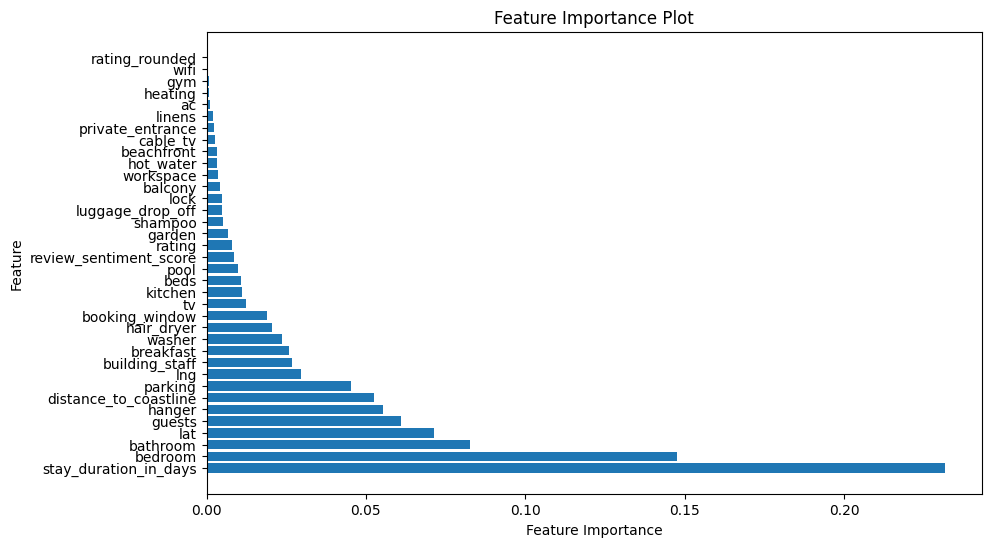

Mean Absolute Error: 154967.85561183593
Best parameters found by GridSearchCV: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


In [29]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Initialize the XGBoost model
model = XGBRegressor()

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances with corresponding column names
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance values
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)